# **Waze Project**

# **Regression modeling**

In this section, you will develop a binomial logistic regression model. Logistic regression is a valuable tool in data science, as it helps estimate the probability of a binary outcome. This approach enables the analysis of multiple predictor variables, providing a more comprehensive and flexible understanding of the relationships within your data.
<br/>

**Objective** The aim of this project is to demonstrate proficiency in building and evaluating a binomial logistic regression model.

**The goal** To construct a binomial logistic regression model and assess its performance.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [4]:
df = pd.read_csv('data/pre_process_waze.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14299 entries, 0 to 14298
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   label                            14299 non-null  object 
 1   sessions                         14299 non-null  int64  
 2   drives                           14299 non-null  int64  
 3   total_sessions                   14299 non-null  float64
 4   n_days_after_onboarding          14299 non-null  int64  
 5   total_navigations_fav1           14299 non-null  int64  
 6   total_navigations_fav2           14299 non-null  int64  
 7   driven_km_drives                 14299 non-null  float64
 8   duration_minutes_drives          14299 non-null  float64
 9   activity_days                    14299 non-null  int64  
 10  driving_days                     14299 non-null  int64  
 11  device                           14299 non-null  object 
 12  km_per_drive      

In [6]:
df.shape

(14299, 22)

In [7]:
df.head(4)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,...,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,percent_of_sessions_to_favorite,device2,label2
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,...,11.632058,138.360267,11.894737,0.953670,1,0.130381,79.430298,0.700931,0,0
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,...,128.186173,1246.901868,9.727273,0.406856,0,0.266854,260.389902,0.253903,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,...,32.201567,382.393602,11.875000,0.841186,0,0.051121,113.953460,0.000000,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,...,22.839778,304.530374,13.333333,0.724968,0,1.089743,93.351141,4.867640,1,0


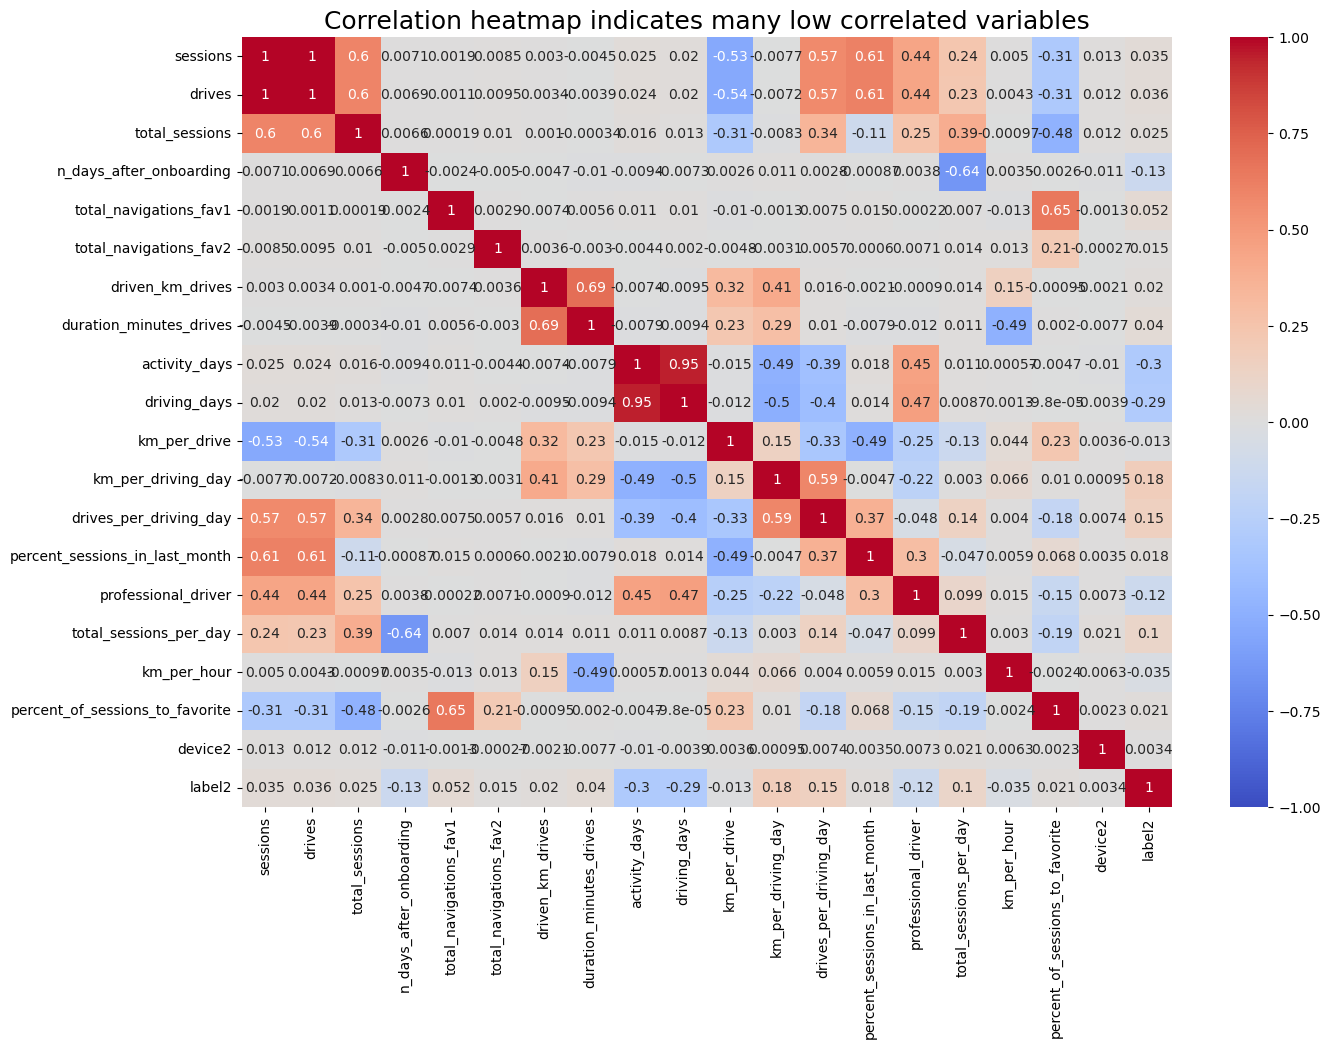

In [8]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

If there are predictor variables that have a Pearson correlation coefficient value greater than the **absolute value of 0.7**, these variables are strongly multicollinear. Therefore, only one of these variables should be used in your model.

**Note:** 0.7 is an arbitrary threshold. Some industries may use 0.6, 0.8, etc.

**Question:** Which variables are multicollinear with each other?

> * *`sessions` and `drives`: 1.0*
<br>
> * *`driving_days` and `activity_days`: 0.95*

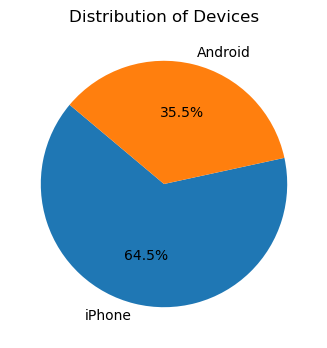

In [9]:
feature = 'device'
plt.figure(figsize=(8, 4))           
plt.pie(df[feature].value_counts(), labels=df[feature].value_counts().index, autopct='%1.1f%%', startangle=140)    
plt.title(f'Distribution of Devices')
plt.show()

### **Dummies variables**

If you have selected `device` as an X variable, you will need to create dummy variables since this variable is categorical.

In cases with many categorical variables, you can use pandas built-in [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), or you can use scikit-learn's [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function.

**Note:** Variables with many categories should only be dummied if absolutely necessary. Each category will result in a coefficient for your model which can lead to overfitting.

Because this dataset only has one remaining categorical feature (`device`), it's not necessary to use one of these special functions. You can just implement the transformation directly.

Create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

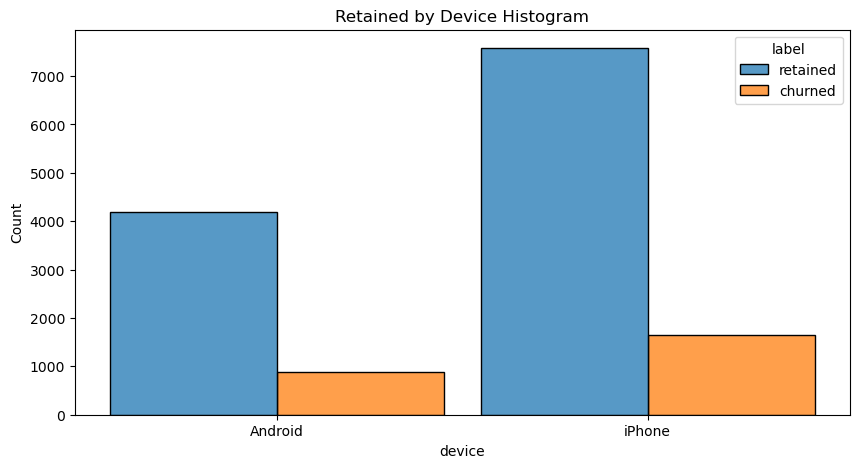

In [10]:
# Histogram
plt.figure(figsize=(10,5))
ax = sns.histplot(x=df['device'], hue=df['label'], multiple='dodge', shrink=0.9)
plt.title('Retained by Device Histogram')
plt.show()

### **Model building**

#### **Assign predictor variables and target**

To build your model you need to determine what X variables you want to include in your model to predict your target&mdash;`label2`.

Drop the following variables and assign the results to `X`:

* `label` (this is the target)
* `label2` (this is the target)
* `device` (this is the non-binary-encoded categorical variable)
* `sessions` (this had high multicollinearity)
* `driving_days` (this had high multicollinearity)

**Note:** Notice that `sessions` and `driving_days` were selected to be dropped, rather than `drives` and `activity_days`. The reason for this is that the features that were kept for modeling had slightly stronger correlations with the target variable than the features that were dropped.

In [11]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

Now, isolate the dependent (target) variable. Assign it to a variable called `y`.

In [12]:
# Isolate target variable
y = df['label2']

#### **Split the data**

Use scikit-learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to perform a train/test split on your data using the X and y variables you assigned above.

**Note 1:** It is important to do a train test to obtain accurate predictions.  You always want to fit your model on your training set and evaluate your model on your test set to avoid data leakage.

**Note 2:** Because the target class is imbalanced (82% retained vs. 18% churned), you want to make sure that you don't get an unlucky split that over- or under-represents the frequency of the minority class. Set the function's `stratify` parameter to `y` to ensure that the minority class appears in both train and test sets in the same proportion that it does in the overall dataset.

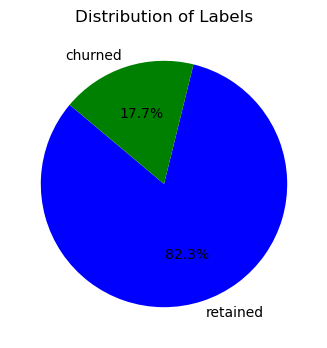

In [13]:
feature = 'label'
plt.figure(figsize=(8, 4))           
plt.pie(df[feature].value_counts(), labels=df[feature].value_counts().index, autopct='%1.1f%%', startangle=140,colors=['blue', 'green'])    
plt.title(f'Distribution of Labels')
plt.show()

## Balancing Data 

In [14]:
# Apply SMOTE before splitting the data
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

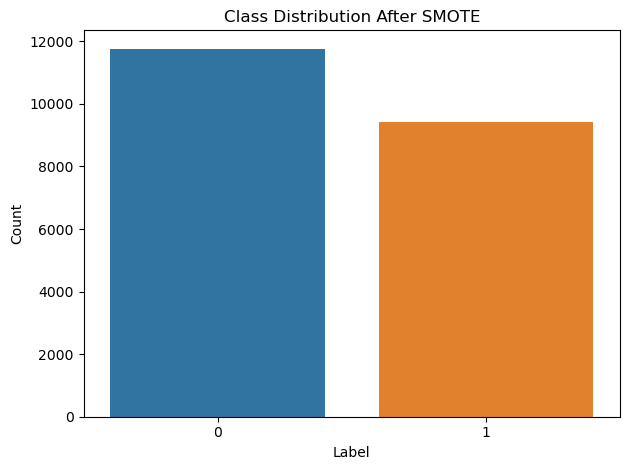

In [15]:
# Define custom colors for the labels
colors = ['#1f77b4', '#ff7f0e']  # Example: blue for 0, orange for 1

# Plot the class distribution after SMOTE
plt.plot()
sns.countplot(x=pd.Series(y_res), palette=colors)
plt.title("Class Distribution After SMOTE")
plt.xlabel('Label')
plt.ylabel('Count')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [16]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, random_state=42)

In [17]:
X_train.head(4)

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,percent_of_sessions_to_favorite,device2
19229,32,89.889534,1109,127,0,3577.735513,895.076898,9,17.804544,425.261736,2.671613,0.174125,0,0.082445,243.580583,3.445930,0
8989,40,112.445186,2351,50,2,3492.513717,2479.946219,12,87.312843,349.251372,4.000000,0.435768,0,0.047829,84.498132,0.462448,0
16883,53,138.991406,141,74,8,1415.525596,626.524510,9,36.404531,213.209133,6.932586,0.370457,0,0.718548,136.243486,0.720126,1
428,200,347.798017,2778,0,19,2220.074354,1725.720626,17,8.132140,130.592609,16.058824,0.971828,1,0.125197,77.187732,0.054629,1


Use scikit-learn to instantiate a logistic regression model. Add the argument `penalty = None`.

It is important to add `penalty = 'none'` since your predictors are unscaled.

Refer to scikit-learn's [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) documentation for more information.

Fit the model on `X_train` and `y_train`.

In [18]:
model = LogisticRegression(penalty='none', max_iter=400)

model.fit(X_train, y_train)

LogisticRegression(max_iter=400, penalty='none')

Call the `.coef_` attribute on the model to get the coefficients of each variable.  The coefficients are in order of how the variables are listed in the dataset.  Remember that the coefficients represent the change in the **log odds** of the target variable for **every one unit increase in X**.

If you want, create a series whose index is the column names and whose values are the coefficients in `model.coef_`.

In [19]:
pd.Series(model.coef_[0], index=X.columns)

drives                             0.004915
total_sessions                     0.000959
n_days_after_onboarding           -0.000296
total_navigations_fav1             0.001915
total_navigations_fav2             0.002202
driven_km_drives                  -0.000118
duration_minutes_drives            0.000394
activity_days                     -0.102695
km_per_drive                       0.000089
km_per_driving_day                 0.000257
drives_per_driving_day            -0.014464
percent_sessions_in_last_month     0.004369
professional_driver               -0.012051
total_sessions_per_day             0.002697
km_per_hour                        0.002639
percent_of_sessions_to_favorite    0.008124
device2                           -0.019515
dtype: float64

Call the model's `intercept_` attribute to get the intercept of the model.

In [20]:
model.intercept_

array([0.00919727])

#### **Check final assumption**

Verify the linear relationship between X and the estimated log odds (known as logits) by making a regplot.

Call the model's `predict_proba()` method to generate the probability of response for each sample in the training data. (The training data is the argument to the method.) Assign the result to a variable called `training_probabilities`. This results in a 2-D array where each row represents a user in `X_train`. The first column is the probability of the user not churning, and the second column is the probability of the user churning.

In [21]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.51995766, 0.48004234],
       [0.66324069, 0.33675931],
       [0.50394416, 0.49605584],
       ...,
       [0.6104983 , 0.3895017 ],
       [0.65766508, 0.34233492],
       [0.58766013, 0.41233987]])

In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>

1. Create a dataframe called `logit_data` that is a copy of `df`.

2. Create a new column called `logit` in the `logit_data` dataframe. The data in this column should represent the logit for each user.

In [22]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

Plot a regplot where the x-axis represents an independent variable and the y-axis represents the log-odds of the predicted probabilities.

In an exhaustive analysis, this would be plotted for each continuous or discrete predictor variable. Here we show only `activity_days`.

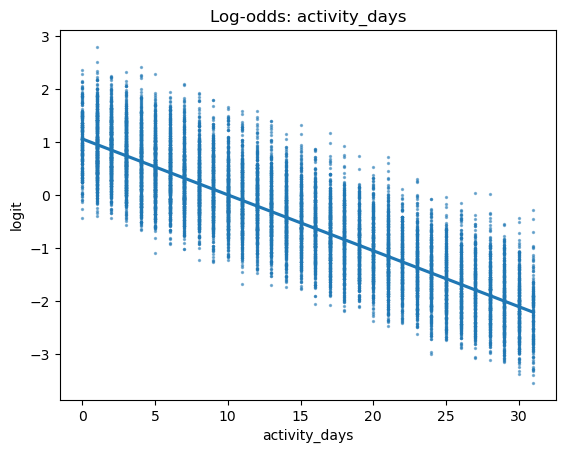

In [23]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

### **Results and evaluation**

If the logistic assumptions are met, the model results can be appropriately interpreted.

Use the code block below to make predictions on the test data.

In [24]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

Now, use the `score()` method on the model with `X_test` and `y_test` as its two arguments. The default score in scikit-learn is **accuracy**.  What is the accuracy of your model?

*Consider:  Is accuracy the best metric to use to evaluate this model?*

In [25]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.6773706082357386

### **Show results with a confusion matrix**
Use the `confusion_matrix` function to obtain a confusion matrix. Use `y_test` and `y_preds` as arguments.

In [26]:
cm = confusion_matrix(y_test, y_preds)

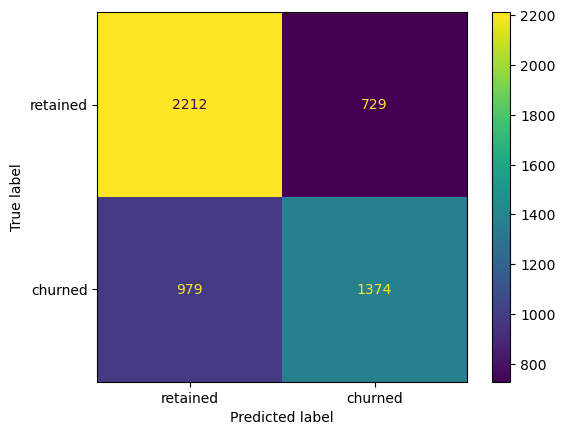

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [28]:
# Calculate precision manually
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.6533523537803139

In [29]:
# Calculate recall manually
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.5839354016149596

In [30]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.69      0.75      0.72      2941
     churned       0.65      0.58      0.62      2353

    accuracy                           0.68      5294
   macro avg       0.67      0.67      0.67      5294
weighted avg       0.68      0.68      0.67      5294



In [31]:
# ROC Curve and AUC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_preds)
roc_auc_log = auc(fpr_log, tpr_log)

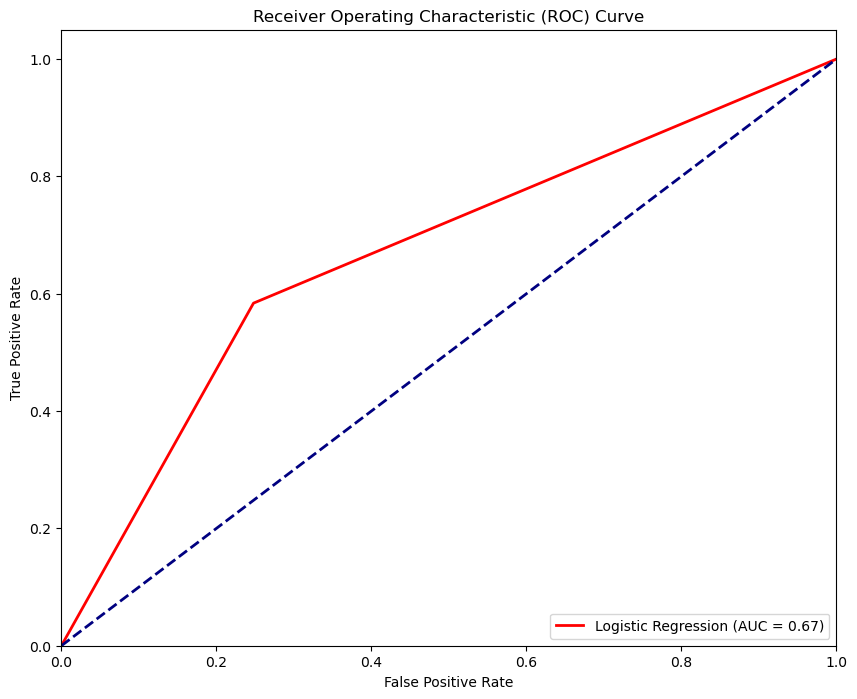

In [32]:
# Plot ROC curve for each model
plt.figure(figsize=(10, 8))
plt.plot(fpr_log, tpr_log, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')

# Plot the diagonal line (random guessing)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()

Generate a bar graph of the model's coefficients for a visual representation of the importance of the model's features.

In [33]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('percent_of_sessions_to_favorite', 0.008123849651726463),
 ('drives', 0.004914929449877053),
 ('percent_sessions_in_last_month', 0.004369194800564202),
 ('total_sessions_per_day', 0.0026969453553442177),
 ('km_per_hour', 0.002638764433852614),
 ('total_navigations_fav2', 0.0022020421721641336),
 ('total_navigations_fav1', 0.0019152693703762518),
 ('total_sessions', 0.0009589597735082868),
 ('duration_minutes_drives', 0.0003943649658228716),
 ('km_per_driving_day', 0.0002573286646128844),
 ('km_per_drive', 8.909050841385613e-05),
 ('driven_km_drives', -0.00011760574650679984),
 ('n_days_after_onboarding', -0.00029563397788318096),
 ('professional_driver', -0.012050822396188762),
 ('drives_per_driving_day', -0.014464439793070475),
 ('device2', -0.019514869273291217),
 ('activity_days', -0.10269537281957598)]

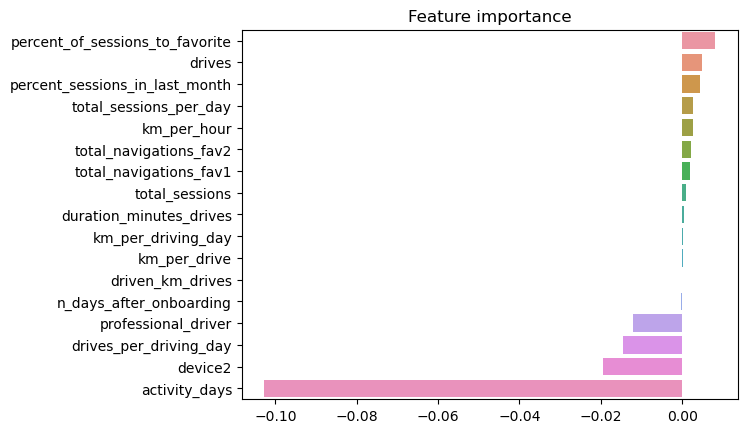

In [34]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

### **Conclusion**

Now that you've built your regression model, the next step is to share your findings with the Waze leadership team. Consider the following questions as you prepare to write your executive summary. Think about key points you may want to share with the team, and what information is most relevant to the user churn project.

**Questions:**


1. What variable most influenced the model's prediction? How? Was this surprising?

> _`activity_days` was by far the most important feature in the model. It had a negative correlation with user churn. This was not surprising, as this variable was very strongly correlated with `drives_per_driving_day`, which was known from EDA to have a negative correlation with churn._

2. Were there any variables that you expected to be stronger predictors than they were?

> _Yes. In previous EDA, user churn rate increased as the values in `km_per_driving_day` increased. The correlation heatmap here in this notebook revealed this variable to have the strongest positive correlation with churn of any of the predictor variables by a relatively large margin. In the model, it was the second-least-important variable._

3. Why might a variable you thought to be important not be important in the model?

> _In a multiple logistic regression model, features can interact with each other and these interactions can result in seemingly counterintuitive relationships. This is both a strength and a weakness of predictive models, as capturing these interactions typically makes a model more predictive while at the same time making the model more difficult to explain._

4. Would you recommend that Waze use this model? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, one of the engineered features (`professional_driver`) was the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._